In [1]:
import os
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=8'

import jax
from jax import config
#config.update("jax_enable_x64", True)
import jax.tree_util as jtu
from abc import ABC
from flax import nnx
from flax import linen
import jax.random as jr
key = jr.key(25)
from jaxtyping import install_import_hook
with install_import_hook("gpjax", "beartype.beartype"):
    import gpjax as gpx
from jax.sharding import Mesh, PartitionSpec, NamedSharding
import jax.numpy as jnp
from datetime import datetime
import blackjax 
from blackjax.smc import resampling
import tensorflow_probability.substrates.jax.distributions as tfd
import numpy as np
import seaborn as sns
from blackjax.types import Array, ArrayLikeTree, ArrayTree, PRNGKey
import matplotlib.pyplot as plt
import matplotlib
from typing import Callable, NamedTuple, Optional, List
from jax_changepoint import ChangePoints

from sampling import smc
from particles import set_priors, init_particles

# Step necessary for testing sharding, should we want to uset that.
print(f'You have 8 “fake” JAX devices now: {jax.devices()}')

# Create a mesh of two dimensions and annotate each axis with a name.
mesh = Mesh(devices=np.array(jax.devices()).reshape(1, 8),
            axis_names=('data', 'model'))
print(mesh)


/home/janneke/miniforge3/envs/jax/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


You have 8 “fake” JAX devices now: [CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3), CpuDevice(id=4), CpuDevice(id=5), CpuDevice(id=6), CpuDevice(id=7)]
Mesh('data': 1, 'model': 8)


### Some default settings.

In [ ]:
N_particles = 1000
key, subkey = jr.split(key)
data = np.load("data.npz")
X = data["X"]
y = data["y"]
D = gpx.Dataset(X=X, y=y)

### Define (conjugate) model, priors

In [3]:

kernel = ChangePoints(kernels=[gpx.kernels.RBF(), gpx.kernels.RBF()], locations=[50], steepness=[1])
#kernel = gpx.kernels.RBF()
meanf = gpx.mean_functions.Zero()
prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel)
likelihood = gpx.likelihoods.Gaussian(num_datapoints=D.n)

posterior = prior * likelihood
graphdef, params, *static_state = nnx.split(posterior, gpx.parameters.Parameter, ...)
# prior_dict = {"prior": {"kernel": {"variance": tfd.LogNormal(1, 1), "lengthscale": tfd.LogNormal(1, 1)},  # Uncomment for regular RBF kernel
#                         "mean_function": {"constant": tfd.Normal(0, 1)}},
#                "likelihood": {"obs_stddev": tfd.LogNormal(1, 1)}}
               #"latent": tfd.Normal(0, 1)}   # and replace likelihood with this for NonConjugate case

prior_dict = {"prior": {"kernel": {"kernels": {0: {"variance": tfd.LogNormal(0, 1), "lengthscale": tfd.LogNormal(1, 1)},
                                               1: {"variance": tfd.LogNormal(0, 1), "lengthscale": tfd.LogNormal(1, 1)}},
                                    "locations": tfd.Uniform(0, len(X)),
                                    "steepness": tfd.Uniform(0, 10)},
                        "mean_function": {"constant": tfd.Normal(0, 1)}},
                        "likelihood": {"obs_stddev": tfd.LogNormal(1, 1)}}

posterior = set_priors(posterior, prior_dict)
graphdef, params, *static_state = nnx.split(posterior, gpx.parameters.Parameter, ...)
param_dim = sum([p.size for p in jtu.tree_flatten(params)[0]])
particle_list = init_particles(posterior, N_particles, key) 
print(type(particle_list))   ### Should return (Non)ConjugatePosterior

<class 'gpjax.gps.ConjugatePosterior'>


Run the sampling. To edit the HMC kernel parameters, at this point just editing the sampling.py file is easiest. By default, a single MCMC step is done, and 10 integration steps, which on my machine takes 7 minutes or so.

In [ ]:
# with mesh:
#     state_sharded = create_sharded_model(particle_list)
    
params_bijection = gpx.parameters.DEFAULT_BIJECTION
graphdef, params, *static_state = nnx.split(particle_list, nnx.VariableState, ...)
params = gpx.parameters.transform(params, params_bijection, inverse=True)
key, smc_key = jr.split(key)

t = datetime.now()
print(t)
final_state = smc(params, D, graphdef)
params = gpx.parameters.transform(final_state.particles, params_bijection)
final_particles = nnx.merge(graphdef, final_state.particles)  
dt = datetime.now() - t
print("Sampling took", dt.total_seconds())

2025-03-25 17:39:39.453768
N_PART 100


If we do not take that many MCMC steps, we don't find much, unfortunately:

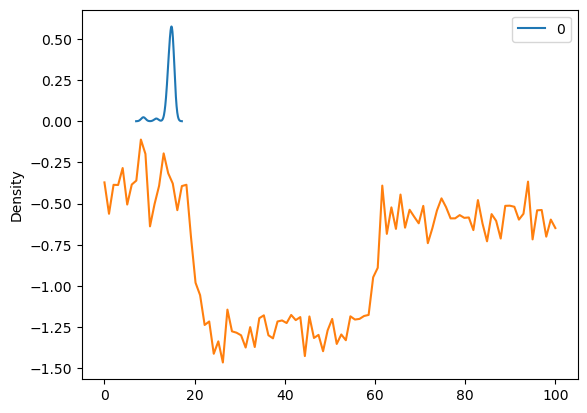

[[  0.        ]
 [  1.01010101]
 [  2.02020202]
 [  3.03030303]
 [  4.04040404]
 [  5.05050505]
 [  6.06060606]
 [  7.07070707]
 [  8.08080808]
 [  9.09090909]
 [ 10.1010101 ]
 [ 11.11111111]
 [ 12.12121212]
 [ 13.13131313]
 [ 14.14141414]
 [ 15.15151515]
 [ 16.16161616]
 [ 17.17171717]
 [ 18.18181818]
 [ 19.19191919]
 [ 20.2020202 ]
 [ 21.21212121]
 [ 22.22222222]
 [ 23.23232323]
 [ 24.24242424]
 [ 25.25252525]
 [ 26.26262626]
 [ 27.27272727]
 [ 28.28282828]
 [ 29.29292929]
 [ 30.3030303 ]
 [ 31.31313131]
 [ 32.32323232]
 [ 33.33333333]
 [ 34.34343434]
 [ 35.35353535]
 [ 36.36363636]
 [ 37.37373737]
 [ 38.38383838]
 [ 39.39393939]
 [ 40.4040404 ]
 [ 41.41414141]
 [ 42.42424242]
 [ 43.43434343]
 [ 44.44444444]
 [ 45.45454545]
 [ 46.46464646]
 [ 47.47474747]
 [ 48.48484848]
 [ 49.49494949]
 [ 50.50505051]
 [ 51.51515152]
 [ 52.52525253]
 [ 53.53535354]
 [ 54.54545455]
 [ 55.55555556]
 [ 56.56565657]
 [ 57.57575758]
 [ 58.58585859]
 [ 59.5959596 ]
 [ 60.60606061]
 [ 61.61616162]
 [ 62.62

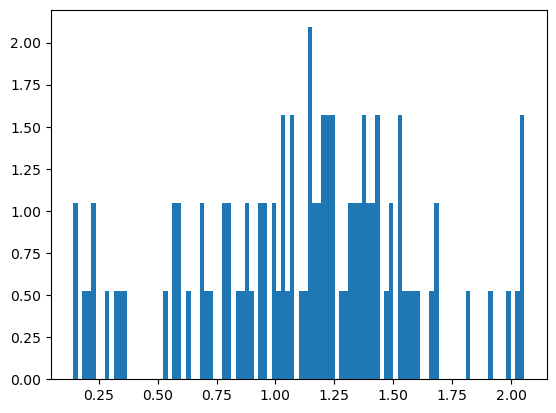

In [ ]:
sns.kdeplot(final_particles.prior.kernel.locations.value)
plt.plot(X, y)
plt.show()
plt.hist(final_particles.prior.kernel.steepness.value, bins=100, density=True)
print(X)

Text(0, 0.5, 'y')

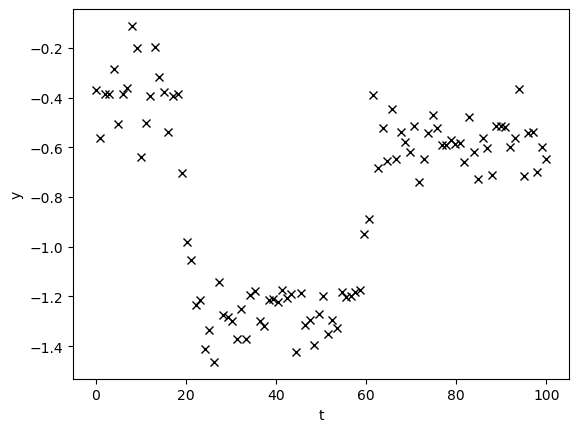

In [ ]:
plt.plot(D.X, D.y, "kx")
plt.xlabel("t")
plt.ylabel("y")